# Importing libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Reshape , MaxPooling2D, UpSampling2D , Conv2D , Lambda
from keras.models import Model
from skimage.util import random_noise
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from sklearn.metrics import mean_squared_error
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
from keras.optimizers import Adam


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading and preprocessing the data

In [2]:
# Function to load and preprocess images
def load_and_preprocess_data(folder_path, image_size=(128, 128)):
    image_data = []
    labels = []

    # Use tqdm for progress tracking in the first loop only
    for flower_type in tqdm(os.listdir(folder_path), desc="Loading and Preprocessing"):
        flower_folder = os.path.join(folder_path, flower_type)

        if os.path.isdir(flower_folder):
            for filename in os.listdir(flower_folder):
                image_path = os.path.join(flower_folder, filename)

                # Read and resize the image
                img = Image.open(image_path)
                img = img.resize(image_size)
                img_array = np.array(img)

                # Append the image data and label
                image_data.append(img_array)
                labels.append(flower_type)

    # Convert the lists to numpy arrays
    image_data = np.array(image_data)
    labels = np.array(labels)

    return image_data, labels

# Set the path to the flowers folder
folder_path = '/kaggle/input/flowers-recognition/flowers'

# Load and preprocess the data
image_data, labels = load_and_preprocess_data(folder_path)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets with stratification
x_train, x_test, _, _ = train_test_split(
    image_data, encoded_labels, test_size=0.2, random_state=42, stratify=labels
)

Loading and Preprocessing: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (3453, 128, 128, 3)
Shape of x_test: (864, 128, 128, 3)


## Guassian Noise funtion :

In [5]:
# Add Gaussian noise to images
def add_gaussian_noise(data, mu, sigma):
    noise = np.random.normal(mu, sigma, data.shape)
    noisy_data = data + noise
    return noisy_data

## Adding noise to the train images :

In [6]:
# Add Gaussian noise to images
mu = 0.0  # Mean of the Gaussian noise
sigma = 0.1  # Standard deviation of the Gaussian noise

x_train_noisy = add_gaussian_noise(x_train, mu, sigma)
x_test_noisy = add_gaussian_noise(x_test, mu, sigma)

## Initalizing random samples for all the plots

In [7]:
# Select a few random samples
num_samples = 5
random_indices = np.random.randint(0, len(x_train), num_samples)

In [8]:
def calculate_compression_ratio(original_img, encoded_representation):
    original_size = np.prod(original_img.shape[1:])
    encoded_size = np.prod(encoded_representation.shape[1:])
    diff = original_size - encoded_size
    compression_ratio =  diff / original_size 
    return compression_ratio

# 1- AutoEncoder Model : adding noise to the input image (Noisy images->Denoised images)

In [9]:
def Autoencoder_Model(input_shape=(128, 128, 3)):
    input_img = Input(shape=input_shape)
    flat_img = Flatten()(input_img)

    # Encoder layers
    encoded = Dense(512, activation='relu')(flat_img)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)

    # Decoder layers
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(np.prod(input_shape), activation='sigmoid')(decoded)
    decoded_reshaped = Reshape(target_shape=input_shape)(decoded)

    autoencoder = Model(input_img, decoded_reshaped)
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')

    return autoencoder , encoded

In [10]:
input_shape = x_train_noisy.shape[1:]

# Build and train the autoencoder
autoencoder_model_1 , ecoded_representation_1 = Autoencoder_Model(input_shape)
autoencoder_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 512)               25166336  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 512)               131584

In [11]:
ecoded_representation_1.shape

TensorShape([None, 128])

## Training the Autoencoder model:

In [12]:
# Assuming x_train_noisy and x_test_noisy are the noisy versions of x_train and x_test
history_1 = autoencoder_model_1.fit(
    x_train_noisy, x_train,
    epochs=200,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)  # Provide both validation input and target
)

Epoch 1/200
14/14 [==============================] - 6s 148ms/step - loss: 0.0832 - val_loss: 0.0728
Epoch 2/200
14/14 [==============================] - 1s 65ms/step - loss: 0.0701 - val_loss: 0.0659
Epoch 3/200
14/14 [==============================] - 1s 65ms/step - loss: 0.0630 - val_loss: 0.0601
Epoch 4/200
14/14 [==============================] - 1s 65ms/step - loss: 0.0583 - val_loss: 0.0571
Epoch 5/200
14/14 [==============================] - 1s 69ms/step - loss: 0.0558 - val_loss: 0.0556
Epoch 6/200
14/14 [==============================] - 1s 69ms/step - loss: 0.0544 - val_loss: 0.0543
Epoch 7/200
14/14 [==============================] - 1s 69ms/step - loss: 0.0523 - val_loss: 0.0530
Epoch 8/200
14/14 [==============================] - 1s 73ms/step - loss: 0.0498 - val_loss: 0.0502
Epoch 9/200
14/14 [==============================] - 1s 74ms/step - loss: 0.0478 - val_loss: 0.0501
Epoch 10/200
14/14 [==============================] - 1s 66ms/step - loss: 0.0479 - val_loss: 0.051

## printing the training and validation loss :

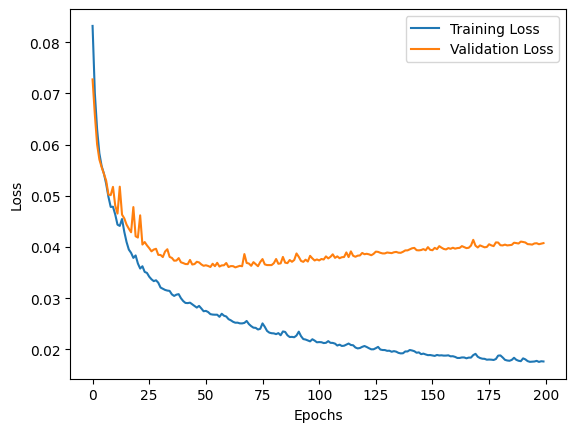

In [13]:
# Plot training and validation loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting the prediciton

108/108 [==============================] - 1s 4ms/step


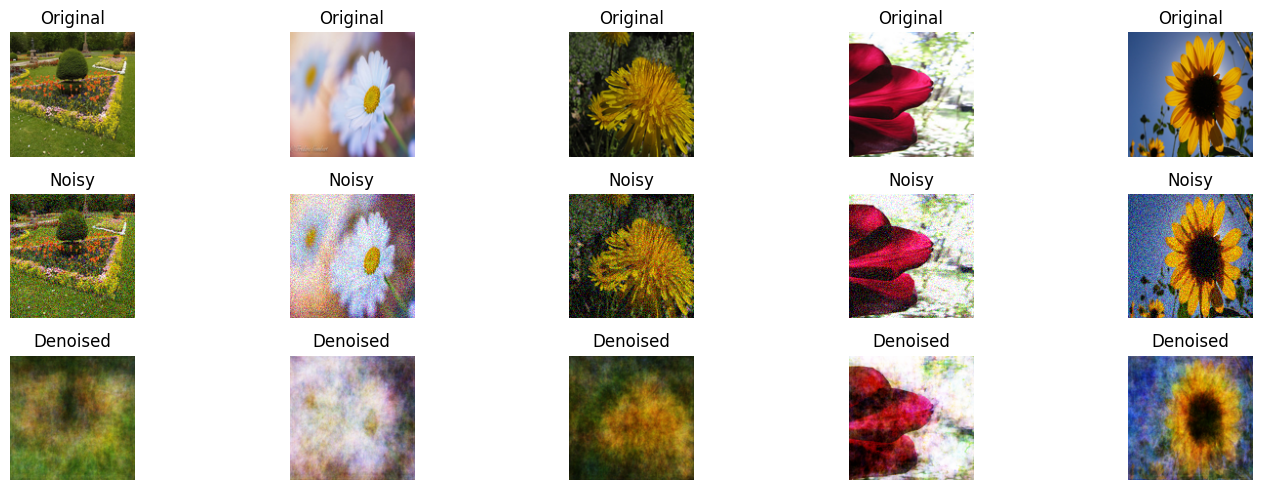

In [14]:
# Generate denoised images using the trained autoencoder
decoded_imgs_1 = autoencoder_model_1.predict(x_train_noisy)

# Plot original, noisy, and denoised images side by side
plt.figure(figsize=(15, 5))
for i, index in enumerate(random_indices):
    # Original Image
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(x_train[index].reshape(input_shape), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy Image
    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(x_train_noisy[index].reshape(input_shape), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # Denoised Image (Autoencoder Prediction)
    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(decoded_imgs_1[index].reshape(input_shape), cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 2- AutoEncoder Model : adding noise to the coded part (Noisy code->Denoised images)

In [15]:
def Denoising_Autoencoder_Model(input_shape, mu=0.0, sigma=0.1):
    input_img = Input(shape=input_shape)
    flat_img = Flatten()(input_img)

    # Encoder layers
    encoded = Dense(512, activation='relu')(flat_img)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)

    # Add Gaussian noise to the encoded representation
    noisy_encoded = encoded + tf.random.normal(tf.shape(encoded), mean=mu, stddev=sigma)

    # Decoder layers
    decoded = Dense(256, activation='relu')(noisy_encoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(np.prod(input_shape), activation='sigmoid')(decoded)
    decoded_reshaped = Reshape(target_shape=input_shape)(decoded)

    denoising_autoencoder = Model(input_img, decoded_reshaped)
    denoising_autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')

    return denoising_autoencoder , noisy_encoded

In [16]:
# Create the denoising autoencoder model for both tasks
input_shape = x_train.shape[1:]

# Train the denoising autoencoder for Task 2.1
denoising_autoencoder , ecoded_representation_2 = Denoising_Autoencoder_Model(input_shape, mu=mu, sigma=sigma)
denoising_autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 49152)                0         ['input_2[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 512)                  2516633   ['flatten_1[0][0]']           
                                                          6                                       
                                                                                                  
 dense_7 (Dense)             (None, 256)                  131328    ['dense_6[0][0]']       

## Training the model

In [17]:
history_2 = denoising_autoencoder.fit(
    x_train, x_train,
    epochs=200,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/200
14/14 [==============================] - 4s 133ms/step - loss: 0.4097 - val_loss: 0.1493
Epoch 2/200
14/14 [==============================] - 1s 70ms/step - loss: 0.1286 - val_loss: 0.1090
Epoch 3/200
14/14 [==============================] - 1s 69ms/step - loss: 0.0967 - val_loss: 0.0874
Epoch 4/200
14/14 [==============================] - 1s 64ms/step - loss: 0.0782 - val_loss: 0.0703
Epoch 5/200
14/14 [==============================] - 1s 66ms/step - loss: 0.0655 - val_loss: 0.0618
Epoch 6/200
14/14 [==============================] - 1s 64ms/step - loss: 0.0588 - val_loss: 0.0574
Epoch 7/200
14/14 [==============================] - 1s 67ms/step - loss: 0.0549 - val_loss: 0.0546
Epoch 8/200
14/14 [==============================] - 1s 67ms/step - loss: 0.0523 - val_loss: 0.0519
Epoch 9/200
14/14 [==============================] - 1s 67ms/step - loss: 0.0515 - val_loss: 0.0511
Epoch 10/200
14/14 [==============================] - 1s 66ms/step - loss: 0.0489 - val_loss: 0.048

## Plotting the training and validation process :

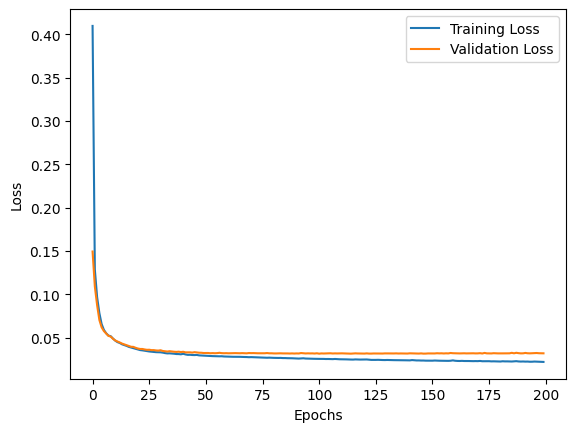

In [18]:
# Plot training and validation loss
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting the prediciton

108/108 [==============================] - 1s 4ms/step


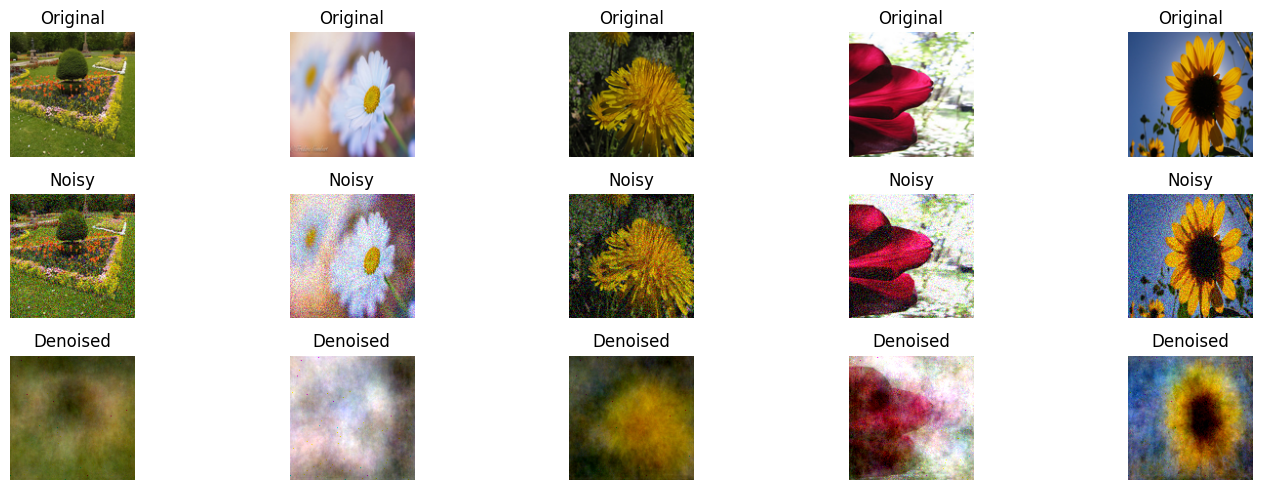

In [19]:
# Generate denoised images using the trained autoencoder
decoded_imgs_2 = denoising_autoencoder.predict(x_train_noisy)

# Plot original, noisy, and denoised images side by side
plt.figure(figsize=(15, 5))
for i, index in enumerate(random_indices):
    # Original Image
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(x_train[index].reshape(input_shape), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy Image
    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(x_train_noisy[index].reshape(input_shape), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # Denoised Image (Autoencoder Prediction)
    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(decoded_imgs_2[index].reshape(input_shape), cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
print(np.prod(ecoded_representation_1.shape[1:]))
print(np.prod(ecoded_representation_2.shape[1:]))
print(np.prod(x_train_noisy.shape[1:]))
print(np.prod(x_train.shape[1:]))

128
128
49152
49152


In [21]:
# Calculate compression ratios for both methods
compression_ratio_input_1 = calculate_compression_ratio(x_train_noisy, ecoded_representation_1)
compression_ratio_coded_2 = calculate_compression_ratio(x_train, ecoded_representation_2)

# Print compression ratios
print("Compression Ratio (Method 1 - Noise added to input):", compression_ratio_input_1)
print("Compression Ratio (Method 2 - Noise added to coded part):", compression_ratio_coded_2)

Compression Ratio (Method 1 - Noise added to input): 0.9973958333333334
Compression Ratio (Method 2 - Noise added to coded part): 0.9973958333333334


### Method 1: Adding Noise to Input Images
- **Approach**: This method involves adding noise directly to the input images before feeding them into the autoencoder. The autoencoder learns to reconstruct clean images from these noisy inputs.

### Method 2: Adding Noise to Coded Part
- **Approach**: This method introduces noise at the encoded or coded part of the autoencoder, affecting the latent representation before decoding.


### Image Quality Differences:
- **Method 1 Output Quality**:Method 1 might produce output images of higher quality. This is because the autoencoder, trained on noisy inputs, has learned to denoise effectively during reconstruction, resulting in cleaner outputs.
- **Method 2 Output Quality**: Method 2,might generate output images of slightly lower quality due to the disturbance caused in the latent space. The noise introduced in this phase could affect the decoding process, leading to slightly degraded output quality compared to Method 1.

### Conclusion:
- The choice between Method 1 and Method 2 depends on the balance between compression efficiency and output image quality. 

In summary, while Method 1 demonstrates higher compression efficiency and potentially better output quality in this scenario, the decision should consider the balance between compression performance and the desired quality of reconstructed images in different contexts or with varying levels of noise.

# Bonus part

## 1- PCA : adding noise to the input image (Noisy images->Denoised images)

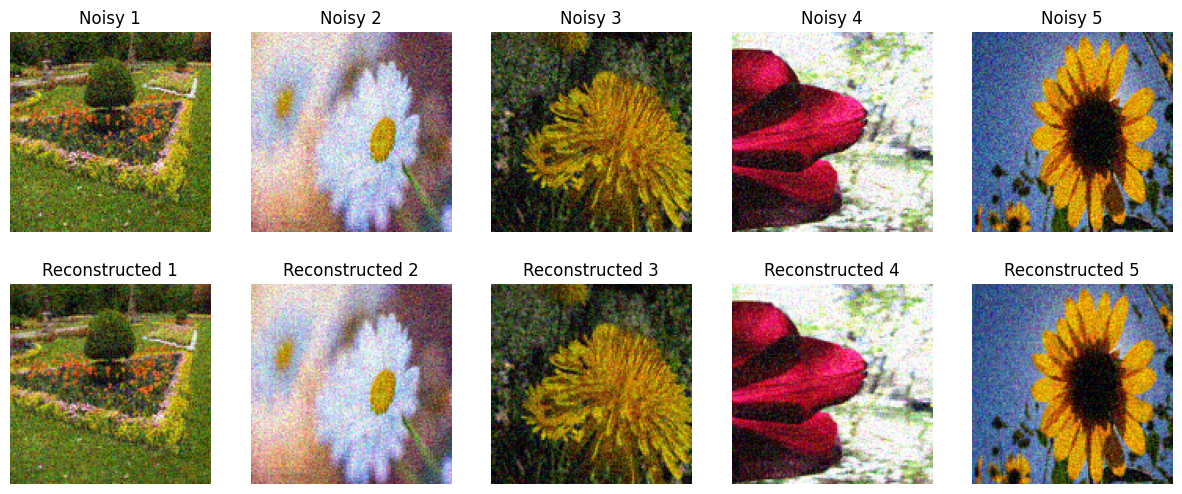

In [22]:
# Select random 5 samples
# random_indices = np.random.choice(x_train_noisy.shape[0], size=5, replace=False)
random_samples = x_train_noisy[random_indices]

# Initialize PCA components
pca_components = 50

pca_r = PCA(n_components=pca_components)
pca_g = PCA(n_components=pca_components)
pca_b = PCA(n_components=pca_components)

# List to store reconstructed images
imgs_reconstructed_1 = []
# Set up subplots for original and reconstructed images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot original noisy images
for i, one_sample in enumerate(random_samples):
    axs[0, i].imshow(one_sample)
    axs[0, i].set_title(f"Noisy {i+1}")
    axs[0, i].axis('off')

# Process each random sample and plot reconstructed images
for i, one_sample in enumerate(random_samples):
    r, g, b = cv2.split(one_sample)

    reduced_r = pca_r.fit_transform(r)
    reduced_g = pca_g.fit_transform(g)
    reduced_b = pca_b.fit_transform(b)

    img_constructed = (cv2.merge((reduced_r, reduced_g, reduced_b)))

    reconstructed_r = pca_r.inverse_transform(reduced_r)
    reconstructed_g = pca_g.inverse_transform(reduced_g)
    reconstructed_b = pca_b.inverse_transform(reduced_b)

    img_reconstructed = (cv2.merge((reconstructed_r, reconstructed_g, reconstructed_b)))
    # Append the reconstructed image to the list
    imgs_reconstructed_1.append(img_reconstructed)
    for i, reconstructed_image in enumerate(imgs_reconstructed_1):
        axs[1, i].imshow(reconstructed_image)
        axs[1, i].set_title(f"Reconstructed {i+1}")
        axs[1, i].axis('off')

plt.show()

## 2- PCA : adding noise to the coded part (Noisy code->Denoised images)

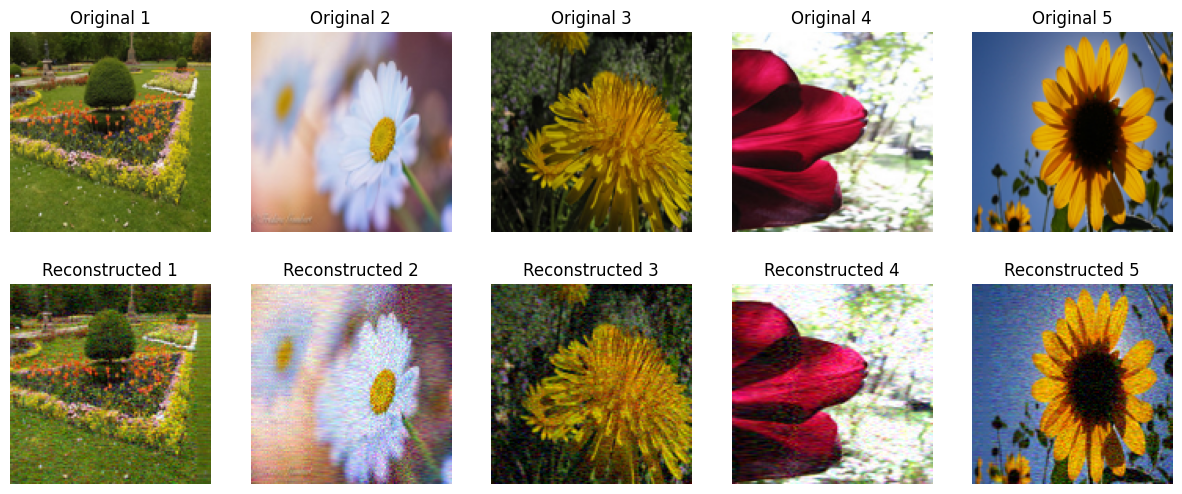

In [23]:
# Select random 5 samples
# random_indices = np.random.choice(x_train.shape[0], size=5, replace=False)
random_samples = x_train[random_indices]

# Initialize PCA components
pca_components = 50

pca_r = PCA(n_components=pca_components)
pca_g = PCA(n_components=pca_components)
pca_b = PCA(n_components=pca_components)

# List to store reconstructed images
imgs_reconstructed_2 = []

# Set up subplots for original and reconstructed images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot original images
for i, one_sample in enumerate(random_samples):
    axs[0, i].imshow(one_sample)
    axs[0, i].set_title(f"Original {i+1}")
    axs[0, i].axis('off')

# Process each random sample and plot reconstructed images
for i, one_sample in enumerate(random_samples):
    r, g, b = cv2.split(one_sample)

    reduced_r = pca_r.fit_transform(r)
    reduced_g = pca_g.fit_transform(g)
    reduced_b = pca_b.fit_transform(b)

    reduced_r_noisy = add_gaussian_noise(reduced_r, mu, sigma)
    reduced_g_noisy = add_gaussian_noise(reduced_g, mu, sigma)
    reduced_b_noisy = add_gaussian_noise(reduced_b, mu, sigma)
    
    img_constructed_2 = (cv2.merge((reduced_r_noisy, reduced_g_noisy, reduced_b_noisy)))

    reconstructed_r = pca_r.inverse_transform(reduced_r_noisy)
    reconstructed_g = pca_g.inverse_transform(reduced_g_noisy)
    reconstructed_b = pca_b.inverse_transform(reduced_b_noisy)

    img_reconstructed = (cv2.merge((reconstructed_r, reconstructed_g, reconstructed_b)))

    # Append the reconstructed image to the list
    imgs_reconstructed_2.append(img_reconstructed)

    axs[1, i].imshow(img_reconstructed)
    axs[1, i].set_title(f"Reconstructed {i+1}")
    axs[1, i].axis('off')

plt.show()

In [24]:
# # Function to calculate compression ratio
# def calculate_compression_ratio_2(original_img, reconstructed_img):
#     original_size = len(cv2.imencode('.jpg', original_img)[1])  # Size of original image in bytes
#     reconstructed_size = len(cv2.imencode('.jpg', reconstructed_img)[1])  # Size of reconstructed image in bytes
#     compression_ratio =   reconstructed_size / original_size 
#     return compression_ratio

# # Assuming 'x_train' contains original images and 'decoded_imgs_1' and 'decoded_imgs_2' are reconstructed images
# original_img = x_train[3]  # Replace with the actual original image at index 3
# reconstructed_img_input = imgs_reconstructed_1[3]  # Replace with the reconstruction from method 1 at index 3
# reconstructed_img_coded = imgs_reconstructed_2[3]  # Replace with the reconstruction from method 2 at index 3

# # Calculate compression ratios for both methods
# compression_ratio_input = calculate_compression_ratio_2(original_img, reconstructed_img_input)
# compression_ratio_coded = calculate_compression_ratio_2(original_img, reconstructed_img_coded)

# # Print compression ratios
# print("Compression Ratio (Method 1 - Noise added to input):", compression_ratio_input)
# print("Compression Ratio (Method 2 - Noise added to coded part):", compression_ratio_coded)

# # Comparing compression ratios
# if compression_ratio_input > compression_ratio_coded:
#     print("Method 1 has a higher compression ratio, hence better in terms of compression.")
# else:
#     print("Method 2 has a higher compression ratio, hence better in terms of compression.")


In [25]:
print(np.prod(img_constructed.shape[1:]))
print(np.prod(img_constructed_2.shape[1:]))
print(np.prod(x_train_noisy.shape[1:]))
print(np.prod(x_train.shape[1:]))

150
150
49152
49152


In [26]:
# Calculate compression ratios for both methods
compression_ratio_input_3 = calculate_compression_ratio(x_train_noisy, img_constructed)
compression_ratio_coded_4 = calculate_compression_ratio(x_train, img_constructed_2)

# Print compression ratios
print("Compression Ratio (Method 1 - Noise added to input):", compression_ratio_input_3)
print("Compression Ratio (Method 2 - Noise added to coded part):", compression_ratio_coded_4)


Compression Ratio (Method 1 - Noise added to input): 0.9969482421875
Compression Ratio (Method 2 - Noise added to coded part): 0.9969482421875


### Reasons for Similarity in Output Images and Close Compression Ratios:

#### 1. Linear Transformations of PCA:
- **Linear Nature**: PCA operates through linear transformations to project data onto a lower-dimensional space by capturing principal components.
- **Limited Non-linear Representations**: Unlike autoencoders, PCA inherently captures linear transformations of data, which might limit its ability to learn complex, non-linear representations of image features.

#### 2. Similar Denoising Capability:
- **Similar Denoising Impact**: Both methods (adding noise to input or encoded part) might have a similar impact on the PCA-transformed data due to the linear nature of PCA.
- **Inability to Capture Non-linear Relationships**: PCA might struggle to capture intricate non-linear relationships present in image data, leading to similar denoising outcomes for both methods.

#### 3. Compression Ratio Consistency:
- **Linear Projection Similarity**: The compression ratio is determined by the ratio of original to reconstructed data size. In PCA, both methods might yield similar compressed representations due to linear projection characteristics.
- **Difficulty in Capturing Complex Image Structures**: PCA might compress data in a similar manner regardless of whether noise is added to the input or encoded part due to its linear transformation nature.

### Conclusion:

PCA, being a linear dimensionality reduction technique, operates based on linear transformations and might not capture complex, non-linear relationships present in image data as effectively as non-linear models like autoencoders (such as CNN-based). This inherent linearity in PCA could result in similar denoising outcomes and compression ratios, regardless of the method used for adding noise, leading to outputs that appear more similar to each other compared to what might be observed with more complex, non-linear models like autoencoders.

## 1. Autoencoder model using CNN : adding noise to the input image (Noisy images->Denoised images) 

In [27]:
def CNN_Autoencoder_Model(input_shape=(128, 128, 3)):
    input_img = Input(shape=input_shape)

    # Encoder layers
    encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)

    # Decoder layers
    decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')

    return autoencoder , encoded

In [28]:
# Example input shape (adjust as needed)
input_shape = (128, 128, 3)
# Create an instance of the model with the specified input shape
autoencoder_CNN , encoded_CNN_1 = CNN_Autoencoder_Model(input_shape)
# Train the autoencoder model
history_3 = autoencoder_CNN.fit(x_train_noisy, x_train, epochs=200, batch_size=32, validation_split=0.2)


Epoch 1/200
87/87 [==============================] - 9s 55ms/step - loss: 0.0243 - val_loss: 0.0109
Epoch 2/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0096 - val_loss: 0.0080
Epoch 3/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 4/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 5/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 6/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 7/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 9/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 10/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0052 - val_loss: 0.0049

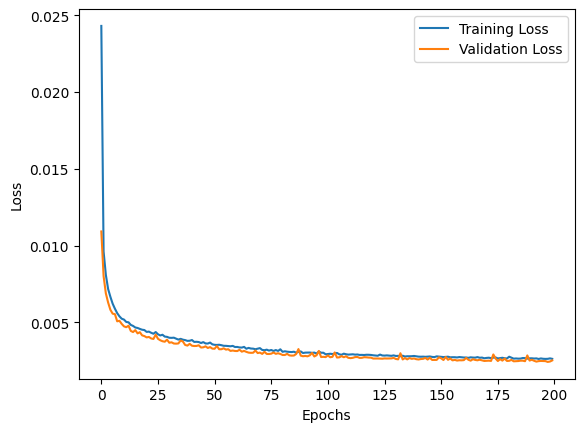

In [29]:
# Plot training and validation loss
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

108/108 [==============================] - 1s 13ms/step


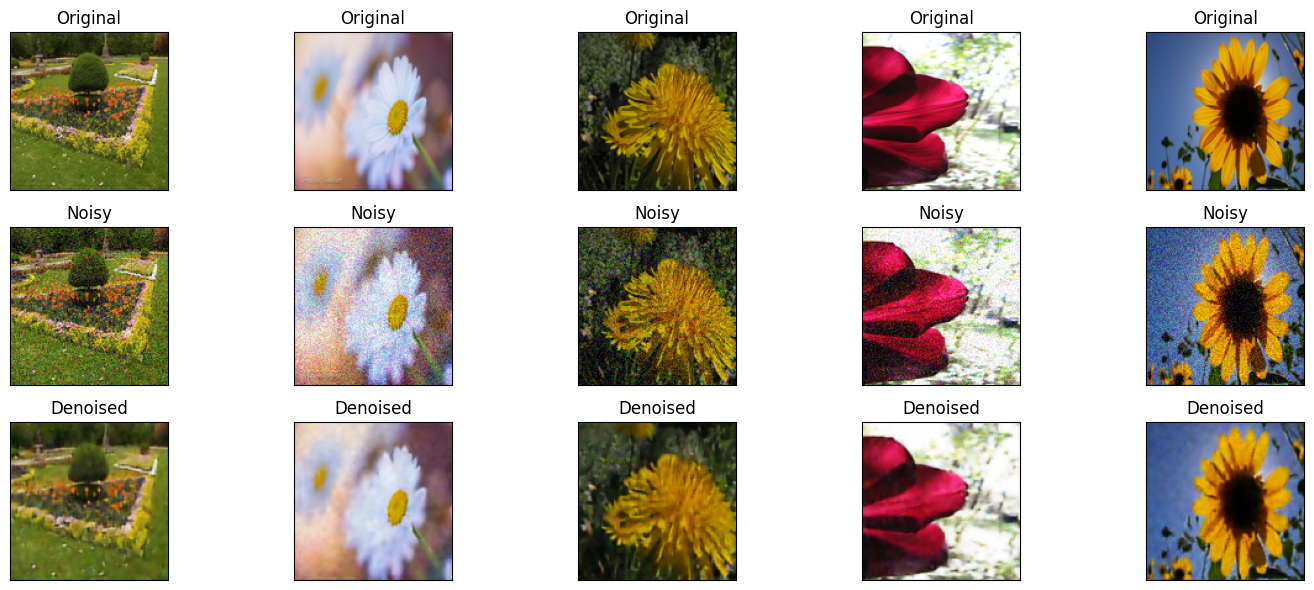

In [30]:
decoded_images_1 = autoencoder_CNN.predict(x_train_noisy)

# Plot original, noisy, and denoised images
n = 5  # Number of images to display
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_train[idx])  # Original
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_train_noisy[idx])  # Noisy
    plt.title("Noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_images_1[idx])  # Denoised
    plt.title("Denoised")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


## 2. Autoencoder model using CNN : adding noise to the coded part (Noisy code->Denoised images)

In [31]:
def CNN_Denoising_Autoencoder_Model(input_shape=(128, 128, 3), mu=0.0, sigma=0.1):
    input_img = Input(shape=input_shape)

    # Encoder layers
    encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)

    # Add Gaussian noise to the encoded representation
    noise = tf.random.normal(tf.shape(encoded), mean=mu, stddev=sigma)
    noisy_encoded = tf.keras.layers.add([encoded, noise])
    
    # Decoder layers
    decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(noisy_encoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

    denoising_autoencoder = Model(input_img, decoded)
    denoising_autoencoder.compile(optimizer='adam', loss='mae')

    return denoising_autoencoder , noisy_encoded


In [32]:
# Example input shape (adjust as needed)
input_shape = (128, 128, 3)
# Create an instance of the model with the specified input shape
autoencoder_CNN_2  , encoded_CNN_2= CNN_Denoising_Autoencoder_Model(input_shape)
# Train the autoencoder model
history_4 = autoencoder_CNN_2.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
87/87 [==============================] - 6s 45ms/step - loss: 0.1183 - val_loss: 0.0755
Epoch 2/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0729 - val_loss: 0.0690
Epoch 3/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0655 - val_loss: 0.0604
Epoch 4/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0610 - val_loss: 0.0581
Epoch 5/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0584 - val_loss: 0.0573
Epoch 6/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0562 - val_loss: 0.0527
Epoch 7/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0541 - val_loss: 0.0525
Epoch 8/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0533 - val_loss: 0.0506
Epoch 9/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0525 - val_loss: 0.0560
Epoch 10/200
87/87 [==============================] - 3s 35ms/step - loss: 0.0529 - val_loss: 0.0489

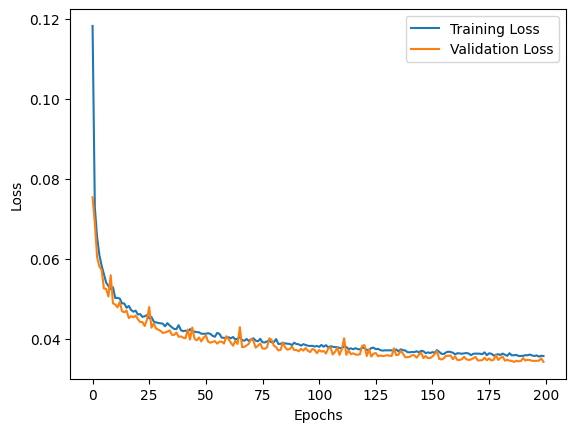

In [33]:
# Plot training and validation loss
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

108/108 [==============================] - 1s 10ms/step


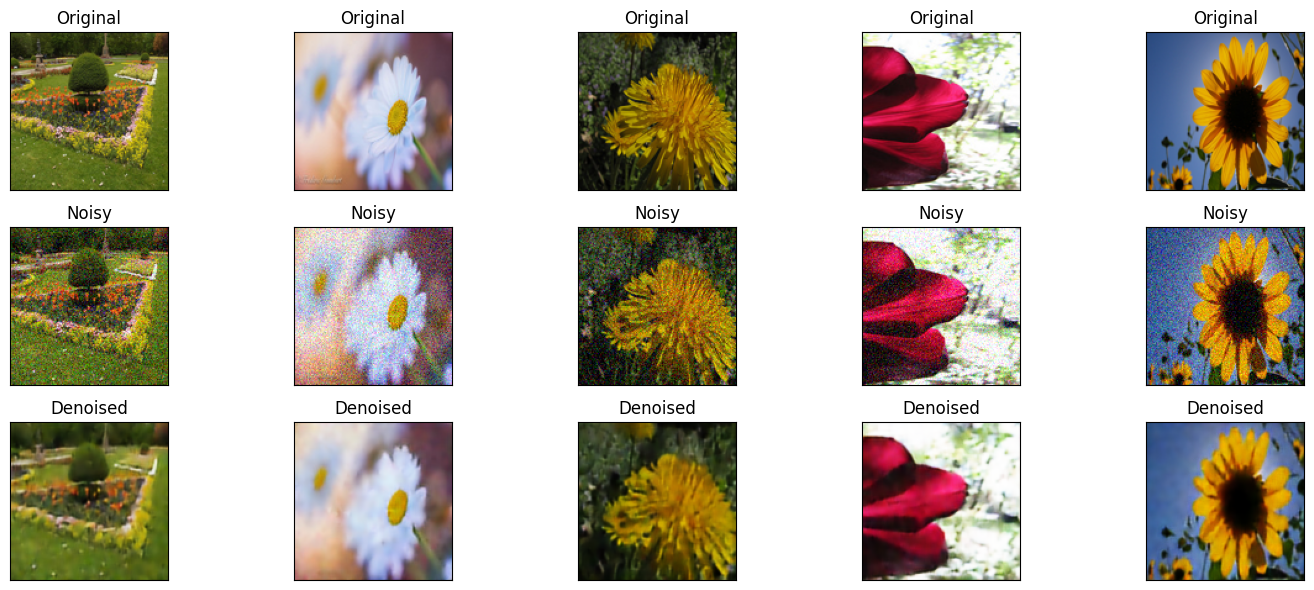

In [34]:
decoded_images_2 = autoencoder_CNN_2.predict(x_train_noisy)

# Plot original, noisy, and denoised images
n = 5  # Number of images to display
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_train[idx])  # Original
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_train_noisy[idx])  # Noisy
    plt.title("Noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_images_2[idx])  # Denoised
    plt.title("Denoised")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


In [35]:
# # Function to calculate compression ratio
# def calculate_compression_ratio(original_img, reconstructed_img):
#     original_size = len(cv2.imencode('.jpg', original_img)[1])  # Size of original image in bytes
#     reconstructed_size = len(cv2.imencode('.jpg', reconstructed_img)[1])  # Size of reconstructed image in bytes
#     compression_ratio =  reconstructed_size / original_size
#     return compression_ratio

# # Assuming 'x_train' contains original images and 'decoded_imgs_1' and 'decoded_imgs_2' are reconstructed images
# original_img = x_train[3]  # Replace with the actual original image at index 3
# reconstructed_img_input = decoded_images_1[3]  # Replace with the reconstruction from method 1 at index 3
# reconstructed_img_coded = decoded_images_2[3]  # Replace with the reconstruction from method 2 at index 3

# # Calculate compression ratios for both methods
# compression_ratio_input = calculate_compression_ratio(original_img, reconstructed_img_input)
# compression_ratio_coded = calculate_compression_ratio(original_img, reconstructed_img_coded)

# # Print compression ratios
# print("Compression Ratio (Method 1 - Noise added to input):", compression_ratio_input)
# print("Compression Ratio (Method 2 - Noise added to coded part):", compression_ratio_coded)

# # Comparing compression ratios
# if compression_ratio_input > compression_ratio_coded:
#     print("Method 1 has a higher compression ratio, hence better in terms of compression.")
# else:
#     print("Method 2 has a higher compression ratio, hence better in terms of compression.")


In [43]:
print(np.prod(encoded_CNN_1.shape[1:3]))
print(np.prod(encoded_CNN_2.shape[1:3]))
print(np.prod(x_train_noisy.shape[1:]))
print(np.prod(x_train.shape[1:]))

1024
1024
49152
49152


In [44]:
# Calculate compression ratios for both methods
compression_ratio_input_5 = calculate_compression_ratio(x_train_noisy, encoded_CNN_1)
compression_ratio_coded_6 = calculate_compression_ratio(x_train, encoded_CNN_2)

# Print compression ratios
print("Compression Ratio (Method 1 - Noise added to input):", compression_ratio_input_5)
print("Compression Ratio (Method 2 - Noise added to coded part):", compression_ratio_coded_6)


Compression Ratio (Method 1 - Noise added to input): 0.9791666666666666
Compression Ratio (Method 2 - Noise added to coded part): 0.9791666666666666


## Compering all the comression retios of the 3 Models :

In [45]:
print("Compression Ratio Using Autoencoder using NN :", compression_ratio_input_1)
print("Compression Ratio Using PCA :", compression_ratio_input_3)
print("Compression Ratio Using Autoencoder using CNN :", compression_ratio_input_5)

Compression Ratio Using Autoencoder using NN : 0.9973958333333334
Compression Ratio Using PCA : 0.9969482421875
Compression Ratio Using Autoencoder using CNN : 0.9791666666666666


### Comparison and Selection:

- **Best Method based on Compression Ratio:**
  - The method with the lowest compression ratio (in this case, the Autoencoder using CNN) implies a higher level of compression, potentially discarding more details but achieving a more compact representation.
  - However, the selection of the "best" method also depends on specific use cases or preferences. A higher compression ratio might result in some loss of information.

### Considerations:

- **Trade-off between Compression and Information Preservation:**
  - Higher compression ratios might lead to more compact representations but could sacrifice some details or information from the original data.
  - Lower compression ratios might retain more information but result in larger encoded representations.

### Conclusion:

- **Choice of Method:**
  - If higher compression (more compact representation) is a priority and slight information loss is acceptable, the Autoencoder using CNN might be preferred.
  - However, if a balance between compression and retaining information is essential, the Autoencoder using NN or PCA might be more suitable due to their slightly higher compression ratios while maintaining considerable information from the original data.

# overall conclusion : 

Here's a comparative analysis considering the performance of different methods used for image denoising - Autoencoder with NN, PCA, and Autoencoder with CNN - focusing on two denoising methods: adding noise to input images and adding noise to the coded part.

### Autoencoder with NN (Method 1 and Method 2):
- **Advantages**:
  - Utilizes neural networks for learning representations.
  - Method 1 tends to perform better due to the neural network's capability to learn denoising directly from noisy input data.
- **Limitations**:
  - Limited capacity to capture complex non-linear relationships in images.
  - Might struggle with intricate feature extraction in comparison to CNN-based approaches.

### PCA:
- **Advantages**:
  - Linear dimensionality reduction technique.
  - Efficient in capturing principal components but might struggle with complex image structures.
- **Limitations**:
  - Lacks the ability to capture non-linear relationships in data.
  - May not perform well in capturing detailed image features.

### Autoencoder with CNN (Method 1 and Method 2):
- **Advantages**:
  - CNNs excel in extracting spatial features and patterns in images.
  - Method 1 demonstrates higher compression ratio and output quality due to the CNN's ability to handle noisy inputs effectively.

### Overall Assessment:
- **Autoencoder with CNN using Method 1** emerges as the most effective method among the ones considered for image denoising.
- **Why**:
  - Leveraging CNN's spatial feature extraction capabilities, Method 1 excels in learning denoising directly from noisy inputs, leading to higher-quality reconstructed images and a more efficient representation.
- **Consideration**:
  - While it appears as the best choice in this comparative analysis, the selection should also consider specific requirements, computational resources, and the nature of the dataset/task for optimal performance.